In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.speedup import calculate_speedups

%load_ext autoreload
%autoreload 2

sns.set_theme()

## Read data

In [2]:
# data from 29-06-2022: thread pool created only for the first run and then re-used
# data from 30-06-2022: thread pool created for each run

threads = 32
sleeping_thresholds = [500]

fixed_frequency_df = None
master_df = None

for i in range(1, threads + 1):
    for st in sleeping_thresholds:
        filename = '30-06-2022/speedup-new-algorithm-{}-threads-{}-us-1.25.csv'.format(i, st)
        new_fixed_freq_df = pd.read_csv(filename)
        new_fixed_freq_df['threads'] = i
        new_fixed_freq_df['branch'] = '{}-1.25'.format(st)
        fixed_frequency_df = pd.concat([fixed_frequency_df, new_fixed_freq_df], ignore_index = True)
        
        filename = '30-06-2022/speedup-master-{}-threads-{}-us-1.25.csv'.format(i, st)
        new_master_df = pd.read_csv(filename)
        new_master_df['threads'] = i
        new_master_df['branch'] = 'master'
        master_df = pd.concat([master_df, new_master_df], ignore_index = True)

## Calculate speedups and prepare to plot

In [3]:
speedups_fixed_freq = calculate_speedups(fixed_frequency_df)
speedups_fixed_freq_df = pd.DataFrame(data=speedups_fixed_freq)

speedups_master = calculate_speedups(master_df)
speedups_master_df = pd.DataFrame(data=speedups_master)

df = pd.concat([fixed_frequency_df, master_df], ignore_index = True)
speedups_df = pd.concat([speedups_fixed_freq_df, speedups_master_df], ignore_index = True)

df.head()

,name,machine_id,threads,cpu_time_us,wall_clock_time_us,package_energy,core_energy,branch
0,MergeSort,dahu-3.grenoble.grid5000.fr,1,75504,75527,6541976,569068,500-1.25
1,MergeSort,dahu-3.grenoble.grid5000.fr,1,74718,74741,6454634,562657,500-1.25
2,MergeSort,dahu-3.grenoble.grid5000.fr,1,74683,74705,6459212,561633,500-1.25
3,MergeSort,dahu-3.grenoble.grid5000.fr,1,75009,75033,6457259,561847,500-1.25
4,MergeSort,dahu-3.grenoble.grid5000.fr,1,74769,74793,6460677,559735,500-1.25


## Speedup curves using 500 us and 1.25

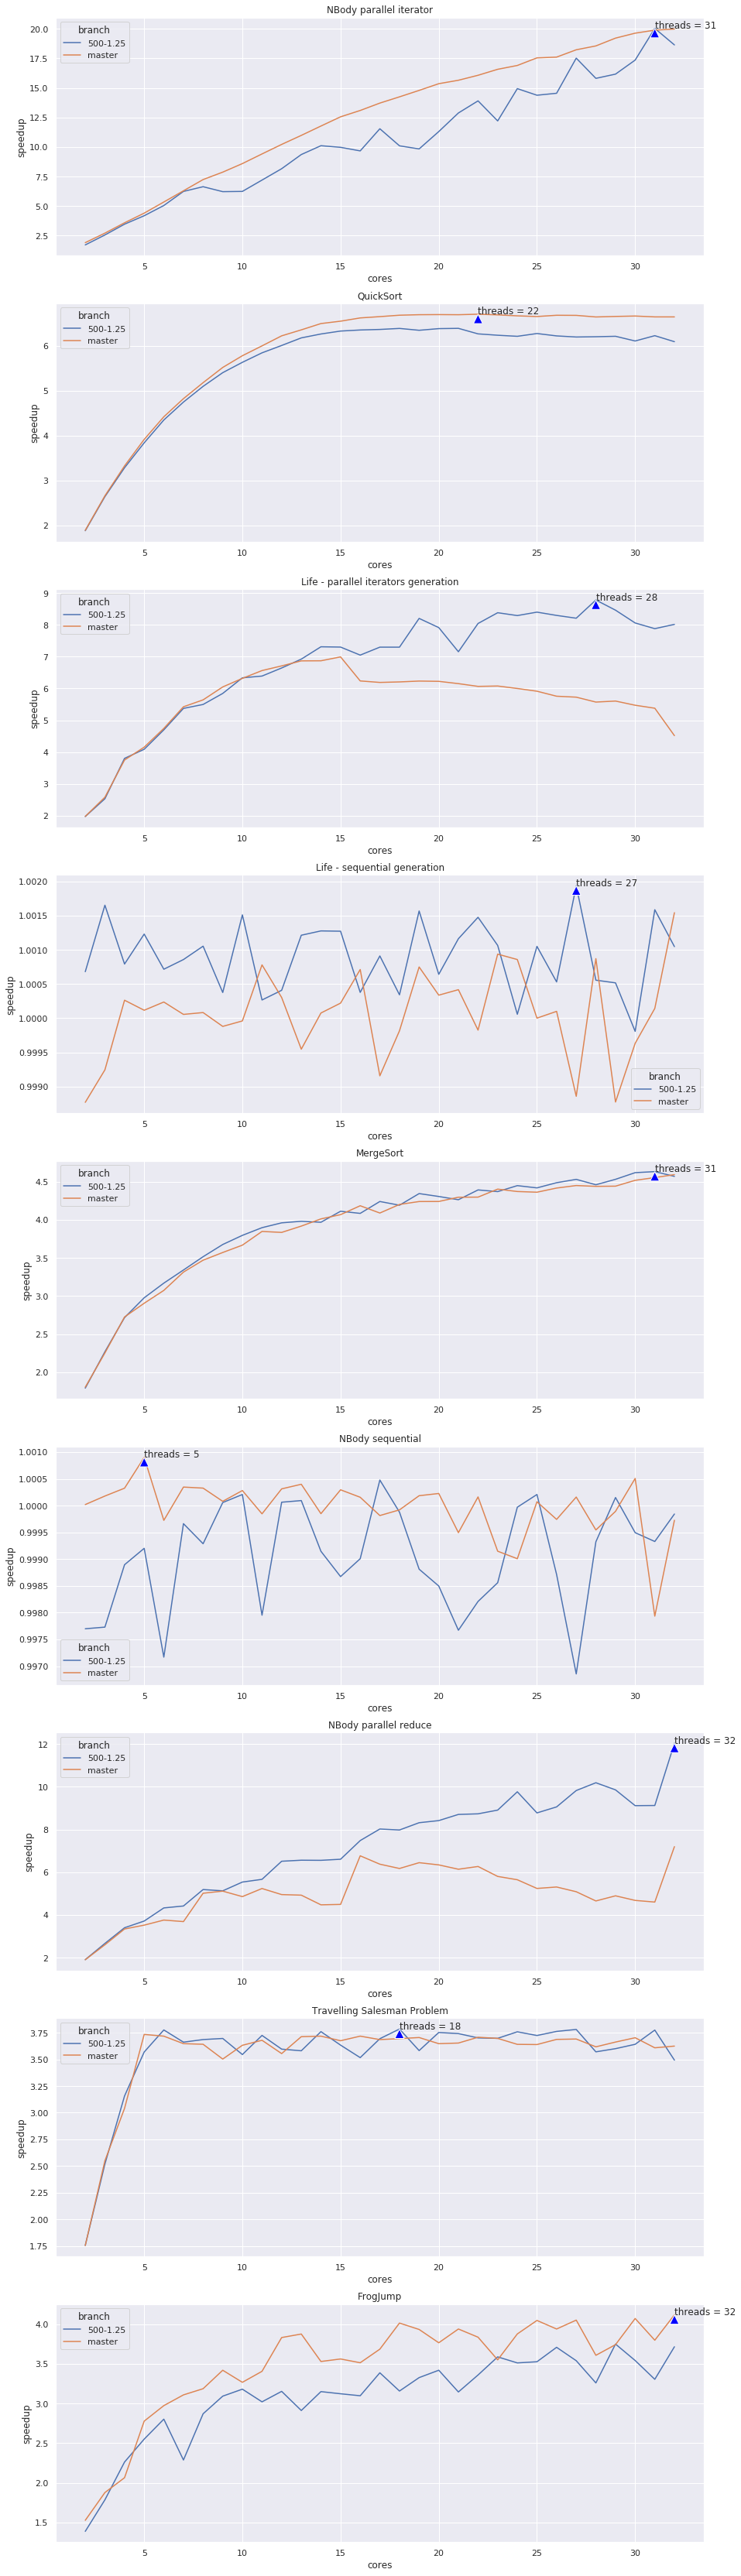

In [4]:
algorithms = set(speedups_df['name'])

fig, axs = plt.subplots(len(algorithms), figsize=(15, 60))

for i, algorithm in enumerate(algorithms):
    algorithm_df = speedups_df[speedups_df['name'] == algorithm]
    
    sns.lineplot(x='cores', y='speedup', hue='branch', data=algorithm_df, ax=axs[i]);
    axs[i].set_title(algorithm);
    
    ymax = max(algorithm_df['speedup'])
    xmax = algorithm_df[algorithm_df['speedup'] == ymax]['cores'].iloc[0]
    axs[i].annotate('threads = {}'.format(xmax), \
                xy=(xmax, ymax), xycoords='data', \
                xytext=(xmax, ymax), textcoords='data', \
                arrowprops=dict(facecolor='blue', shrink=0.05))
    

## Energy

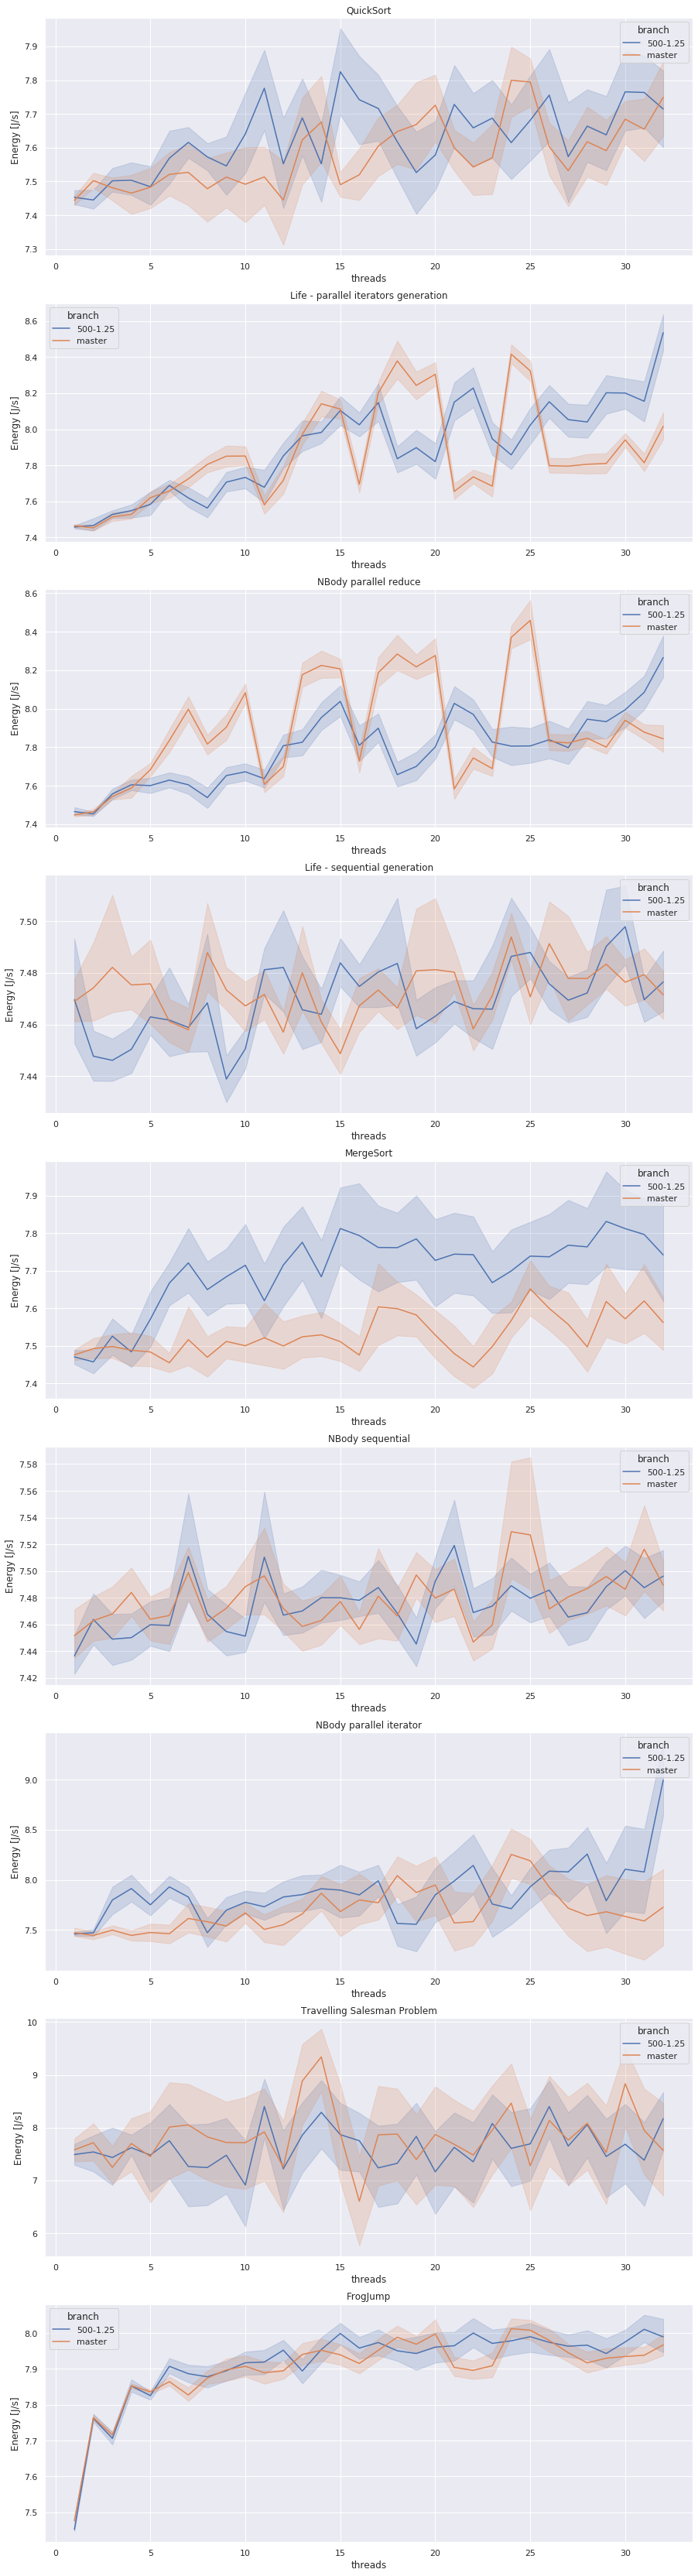

In [5]:
algorithms = set(df['name'])

df['energy'] = df['core_energy'] / df['wall_clock_time_us']

fig, axs = plt.subplots(len(algorithms), figsize=(15, 60))

for i, algorithm in enumerate(algorithms):
    algorithm_df = df[df['name'] == algorithm]
    
    sns.lineplot(x='threads', y='energy', hue='branch', data=algorithm_df, ax=axs[i]);
    axs[i].set_ylabel('Energy [J/s]')
    axs[i].set_title(algorithm);